Author: Nicolas Legrand <nicolas.legrand@cfin.au.dk>

In [87]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from systole.detection import oxi_peaks, rr_artefacts

sns.set_context('talk')

Remove subject

In [88]:
remove = ['sub_0037', 'sub_0075', 'sub_0106', 'sub_0126', 'sub_0165', 'sub_0175']

# Signal quality check

In [89]:
path = os.path.join(os.path.abspath(os.path.join(os.getcwd(), os.pardir)), 'data', 'raw', 'HBC')
subList = os.listdir(path)

check_df = pd.DataFrame([])
for subject in subList:
    if subject not in remove:
        try:
            df = pd.read_csv(os.path.join(path, subject, 'ratings.txt'))
            for i in range(6):
                ppg = np.load(os.path.join(path, subject, f'trial_{i}.npy'))  # Load PPG signal
                signal, peaks = oxi_peaks(ppg, clean_extra=True)  # Find systolic peaks
                
                # Detected heartbeat in the time window of interest
                l = len(signal)/1000
                peaks = peaks[int(l - (3+df.Duration.iloc[i]))*1000:int((l-3)*1000)]

                rr = np.diff(np.where(peaks)[0])  # Convert to RR time series
                artefacts = rr_artefacts(rr)

                for metric, value in zip(['PPG_Mean', 'PPG_std', 'nPeaks', 'nMissed', 'nExtra', 'nEctopic', 'nLong', 'nShort'], 
                                         [np.mean(ppg), np.std(ppg), sum(peaks), artefacts['missed'].sum(), artefacts['extra'].sum(), 
                                          artefacts['ectopic'].sum(), artefacts['long'].sum(), artefacts['short'].sum()]):

                    check_df = check_df.append({'Subject': subject,
                                                'Trial': i,
                                                'Metric': metric,
                                                'Value': value
                                               }, ignore_index=True)
        except:
            print(f'Subject {subject} not found.')        

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: UserWarning: FixedFormatter should only be used together with FixedLocator
  import sys


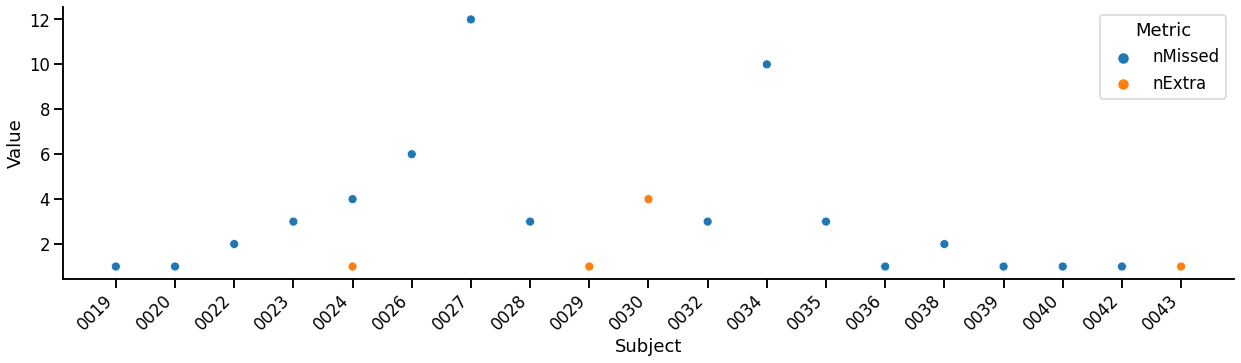

In [90]:
check_df = check_df.groupby(['Subject', 'Metric'], as_index=False).sum()

fig, ax = plt.subplots(figsize=(21, 5))
sns.scatterplot(data=check_df[(check_df.Metric.isin(['nMissed', 'nExtra',])) & (check_df.Value > 0)], 
                x='Subject', y='Value', hue='Metric', ax=ax)
x_labels = [s[4:] for s in check_df.Subject.unique()]
ax.set_xticklabels(x_labels, rotation=45, horizontalalignment='right')
sns.despine()
plt.show()

# HBC scores

In [98]:
path = os.path.join(os.path.abspath(os.path.join(os.getcwd(), os.pardir)), 'data', 'raw', 'HBC')
subList = os.listdir(path)

scores_df = pd.DataFrame([])
for subject in subList:
    if subject not in remove:
        try:
            df = pd.read_csv(os.path.join(path, subject, 'processed.txt'), index_col=0)
            df['Subject'] = subject
            scores_df = scores_df.append(df, ignore_index=True)
        except:
            print(f'Subject {subject} not found.')        

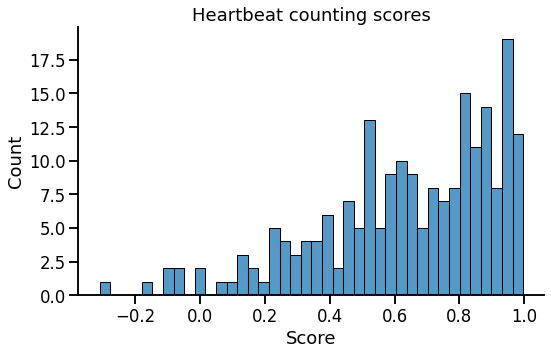

In [106]:
fig, ax = plt.subplots(ncols=1, figsize=(8, 5))
sns.histplot(data=scores_df.groupby(['Subject'], as_index=False).mean(), x='Score', ax=ax, bins=40)
plt.tight_layout()
plt.title('Heartbeat counting scores')
sns.despine()

In [111]:
scores_df.groupby(['Subject'], as_index=False).mean()[['Subject', 'Score']].to_csv(os.path.join(os.path.abspath(os.path.join(os.getcwd(), os.pardir)), 'data', 'hbc.txt'), index=False)